In [170]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import math
import cv2

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])   

data = torchvision.datasets.MNIST(root=".", download=True, transform=transform)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [ ]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

def schedule_beta(timesteps=250, start=0.001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_values_by_index(vals, t, x_shape):
    batch_size = t.shape[0]
    out = torch.gather(vals, -1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_values_by_index(sqrt_alpha_cprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_values_by_index(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 500
betas = schedule_beta(timesteps=T)
alphas = 1.0 - betas
alpha_cprod = torch.cumprod(alphas, 0)
alpha_cprod_prev = F.pad(alpha_cprod[:-1], (1, 0), value=1.0)
sqrt_alpha_cprod = torch.sqrt(alpha_cprod)
one_minus_sqrt_alpha_cprod = torch.sqrt(1 - alpha_cprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alpha_cprod)
posterior_variance = betas * (1. - alpha_cprod_prev) / (1. - alpha_cprod)

In [ ]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion(image, t)
    plt.imshow(img[0].reshape(28, 28, 1))

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=32):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

    def forward(self, x, t):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bnorm1(x)
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        x = x + time_emb
        x = self.bnorm2(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
class UNet_Encoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x, t):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x, t)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs
    
class UNet_Decoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1], 2, 2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]) 
        
    def forward(self, x, t, encoder_features):
        for i in range(len(self.chs)-1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x, t)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class UNet(nn.Module):
    def __init__(self, enc_chs=(1, 32, 64, 128), dec_chs=(128, 64, 32), num_class=1, retain_dim=True, out_size=(28, 28), time_emb_dim=32):
        super().__init__()
        self.encoder = UNet_Encoder(enc_chs)
        self.decoder = UNet_Decoder(dec_chs)
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.out_size = out_size
        self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim = retain_dim

    def forward(self, x, t):
        t = self.time_mlp(t)
        enc_ftrs = self.encoder(x, t)
        out = self.decoder(x=enc_ftrs[::-1][0], encoder_features=enc_ftrs[::-1][1:], t=t)
        out = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_size)
        return out

In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [192]:
@torch.no_grad()
def sample_timestep(x, t, model):
    betas_t = get_values_by_index(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_values_by_index(
        one_minus_sqrt_alpha_cprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_values_by_index(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_values_by_index(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model, device="cpu"):
    # Sample noise
    img_size = 28
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, model)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            plt.imshow(img.reshape(28, 28, 1))
    plt.show()  

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr)
epochs = 50

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        t = torch.randint(0, T, size=(len(batch[0]), ), device=device)
        loss = get_loss(model, batch[0], t)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image(model)


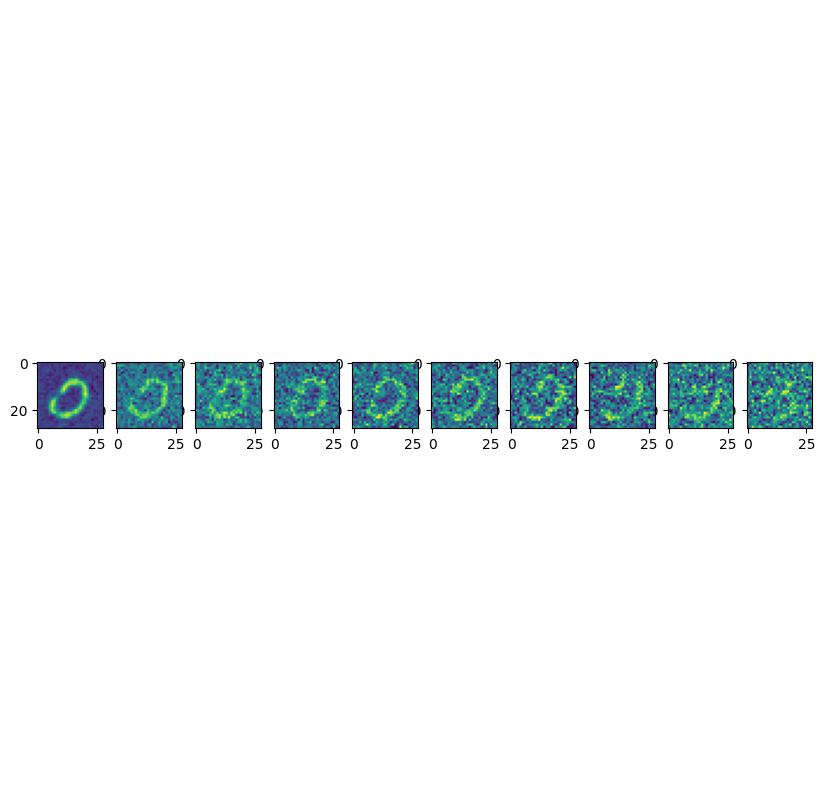

In [195]:

img_size = 28
img = torch.randn((1, 1, img_size, img_size), device=device)
plt.figure(figsize=(10, 10))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for i in range(0, T)[::-1]:
    t = torch.full((1, ), i, device=device, dtype=torch.long)
    img = sample_timestep(img, t, model)
    img = torch.clamp(img, -1.0, 1.0)
    if i % stepsize == 0:
        plt.subplot(1, num_images, int(i / stepsize) + 1)
        plt.imshow(img.reshape(28, 28, 1))
plt.show()  